In [1]:
import gurobipy as gp
from gurobipy import Model, GRB, quicksum
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import numpy as np
import seaborn as sns
from IPython.display import display
from matplotlib.ticker import MaxNLocator
import random

# === Problem Setup ===
n = 100  # Number of MAFs (tasks)
m = 5  # Number of processing units
K = 5  # Number of energy levels

L_levels = [20, 18, 12, 7, 3]  # Delay per energy level
E_levels = [10, 30, 40, 45, 120]   # Energy consumption per energy class
E_PU_max = [9000] * m  # Maximum energy consumption per processing unit
CPU_capacity = [2000] * m  # CPU resources per processing unit
f_v_levels = [20, 30, 40, 60, 80]  # CPU requirements for each MAF
C_total_max = 12000  # Total system resource capacity
P_idle = [18] * m  # Idle power consumption per PU
T_total = 400  # Total system execution time
P_max = [30] * m  # PU Full-load power consumption
# Task Chains
num_chains = 10
chain_tasks = {i: list(range(i * 10, (i + 1) * 10)) for i in range(num_chains)}
L_max = [200] * num_chains




In [2]:

def configure_model(model):
    model.Params.OutputFlag = 0
    model.Params.TimeLimit = 400
    model.Params.MIPGap = 0.05
    model.Params.Presolve = 2
    model.Params.Method = 2
    model.Params.Threads = 8

def run_gurobi_model(alpha_1, alpha_2, alpha_3, baseline=False, chain_enabled=None):
    model = Model("MAF_Model")
    configure_model(model)

    # === 构建 task 到 chain 的映射 ===
    task_to_chains = {i: [] for i in range(n)}
    for k, task_list in chain_tasks.items():
        for i in task_list:
            task_to_chains[i].append(k)

    # === Definition of variables ===
    delta = model.addVars(n, vtype=GRB.BINARY, name="delta")
    w = model.addVars(n, m, vtype=GRB.BINARY, name="w")
    y = model.addVars(n, K, vtype=GRB.BINARY, name="y")
    E_PU = model.addVars(m, vtype=GRB.CONTINUOUS, name="E_PU")
    z_chain_k = model.addVars(num_chains, vtype=GRB.BINARY, name="z_chain_k")  
    U_j = model.addVars(m, vtype=GRB.CONTINUOUS, name="U")
    L_iK = model.addVars(n, vtype=GRB.CONTINUOUS, name="L_iK")

    # === 任务链约束 ===
    for k in range(num_chains):
        chain = chain_tasks[k]

        # 禁用某些链
        if chain_enabled is not None and chain_enabled.get(k, 1) == 0:
            model.addConstr(z_chain_k[k] == 0, name=f"Disabled_Chain_{k}")
            continue

        # 链被激活必须所有任务被接受
        model.addConstr(quicksum(delta[i] for i in chain) >= z_chain_k[k] * len(chain), name=f"Chain_{k}_Activation")

        # 链未被激活，任务也不能被接受（隐含在 delta <= sum(z_chain_k) 中）

        # End-to-End Latency 约束
        execution_time_sum = quicksum(quicksum(y[i, e] * L_levels[e] for e in range(K)) * delta[i] for i in chain)
        communication_delay = len(chain) - 1
        model.addConstr(
            execution_time_sum + communication_delay <= L_max[k] * z_chain_k[k] + (1 - z_chain_k[k]) * 1e-6,
            name=f"EndToEndLatency_Chain_{k}"
        )

    # === Chain 控制 Task 激活：只有链激活才允许任务激活 ===
    for i in range(n):
        if task_to_chains[i]:
            model.addConstr(delta[i] <= quicksum(z_chain_k[k] for k in task_to_chains[i]),
                            name=f"delta_chain_dependency_{i}")

    # === Task 能耗等级与部署一致性约束 ===
    for i in range(n):
        model.addConstr(quicksum(w[i, j] for j in range(m)) == delta[i], name=f"TaskAllocation_{i}")
        model.addConstr(quicksum(y[i, e] for e in range(K)) == delta[i], name=f"TaskEnergyLevel_{i}")
        model.addConstr(L_iK[i] == quicksum(y[i, k] * L_levels[k] for k in range(K)), name=f"L_iK_Calc_{i}")

        # 显式限制未激活任务的能耗等级选择为 0
        for e in range(K):
            model.addConstr(y[i, e] <= delta[i], name=f"TaskEnergyLevelZero_{i}_{e}")
        for j in range(m):
            model.addConstr(w[i, j] <= delta[i], name=f"TaskPUAssignmentZero_{i}_{j}")


    # === PU Calculation time & resource limits ===
    for j in range(m):
        execution_time = quicksum(w[i, j] * L_iK[i] for i in range(n))
        model.addConstr(U_j[j] == execution_time / T_total)
        idle_time = T_total - execution_time  

        # Calculate PU energy consumption
        model.addConstr(E_PU[j] == P_idle[j] * idle_time + (P_max[j] - P_idle[j]) * U_j[j] * T_total)

        # PU Maximum energy consumption limit
        model.addConstr(E_PU[j] <= E_PU_max[j], name=f"PU_{j}_EnergyLimit")

        # Load balancing of tasks
        #model.addConstr(quicksum(w[i, j] for i in range(n)) <= n / m + 5, name=f"PU_{j}_LoadBalance")

    # === PU 资源限制 ===
    for j in range(m):
        model.addConstr(
            quicksum(w[i, j] * quicksum(f_v_levels[e] * y[i, e] for e in range(K)) for i in range(n)) <= CPU_capacity[j],
            name=f"PU_{j}_CPU_Limit"
        )

    # === 系统整体资源限制 ===
    model.addConstr(
        quicksum(w[i, j] * quicksum(f_v_levels[e] * y[i, e] for e in range(K)) for i in range(n) for j in range(m)) <= C_total_max,
        name="SystemTotalResourceLimit"
    )


    # === Baseline ===
    if baseline:
        model.addConstrs((y[i, K-1] == delta[i] for i in range(n)), name="BaselineMaxEnergy")

    # === objective function ===
    obj = (
        alpha_1 * quicksum(delta[i] for i in range(n))  
        - alpha_2 * quicksum(y[i, e] * E_levels[e] for i in range(n) for e in range(K))
        - alpha_3 * quicksum(E_PU[j] for j in range(m))
    )

    model.setObjective(obj, GRB.MAXIMIZE)
    model.optimize()
    num_tasks_selected = sum(delta[i].X for i in range(n))
    print(f"✅ 被接受的任务数: {num_tasks_selected} / {n}")

    return model 


def print_chain_status(model):
    print("\n🔍 每条链激活状态与任务 delta 值：")
    for k in range(num_chains):
        z_val = model.getVarByName(f"z_chain_k[{k}]").X
        print(f"\nChain {k} -> z_chain_k = {z_val}")
        for i in chain_tasks[k]:
            delta_val = model.getVarByName(f"delta[{i}]").X
            print(f"  Task {i}: delta = {delta_val}")


# === MAF Chain Acceptance Rate ===
def calculate_acceptance_rate(model):
    if model is None:
        return 0  #
    
    accepted_chains = sum(1 for k in range(num_chains) if model.getVarByName(f"z_chain_k[{k}]").X > 0.5)
    return accepted_chains / num_chains  # 

def calculate_total_energy(model):
    if model is None:
        return 0, 0

    maf_energy = sum(
        model.getVarByName(f"y[{i},{e}]").X * E_levels[e]
        for i in range(n) for e in range(K)
    )

    pu_energy = sum(
        model.getVarByName(f"E_PU[{j}]").X
        for j in range(m)
    )

    return maf_energy, pu_energy

def extract_results(model):
    maf_energy_levels = np.zeros(n, dtype=int)
    maf_pu_assignments = np.zeros(n, dtype=int)
    
    if model is None:
        return maf_energy_levels, maf_pu_assignments
    
    for i in range(n):
        for e in range(K):
            var_name = f"y[{i},{e}]"
            var = model.getVarByName(var_name)
            if var is not None and var.x > 0.5:
                maf_energy_levels[i] = e + 1
                break  
       
        for j in range(m):
            var_name = f"w[{i},{j}]"
            var = model.getVarByName(var_name)
            if var is not None and var.x > 0.5:
                maf_pu_assignments[i] = j + 1
                break  
    
    return maf_energy_levels, maf_pu_assignments

In [3]:
# ✅ 增强 Greedy 实现：保持与 Gurobi 相同的约束，包括系统总资源限制 C_total_max

def run_heuristic_model_with_constraints(chain_enabled=None):
    delta = [0] * n
    y = [-1] * n  # -1 表示未分配能耗等级
    w = [-1] * n  # -1 表示未分配PU

    pu_remaining_cpu = CPU_capacity[:]
    pu_total_energy = [0] * m
    pu_workload = [0] * m
    total_cpu_used = 0
    accepted_chains = 0

    for k in range(num_chains):
        if chain_enabled and chain_enabled.get(k, 1) == 0:
            continue

        task_list = chain_tasks[k]
        chain_latency = 0
        chain_cpu = 0
        task_energy_levels = []
        task_cpu_usage = []

        # 为每个任务选择最低能耗等级，使得延迟可接受
        for i in task_list:
            for level in range(K):
                latency = L_levels[level]
                cpu = f_v_levels[level]
                if latency + (len(task_list)-1) <= L_max[k]:
                    task_energy_levels.append(level)
                    task_cpu_usage.append(cpu)
                    chain_latency += latency
                    chain_cpu += cpu
                    break
            else:
                break
        else:
            # 再加上总系统资源限制检查
            if total_cpu_used + chain_cpu > C_total_max:
                continue

            # 找一个能承载这条链任务的PU
            for j in range(m):
                if pu_remaining_cpu[j] >= chain_cpu:
                    for idx, i in enumerate(task_list):
                        delta[i] = 1
                        y[i] = task_energy_levels[idx]
                        w[i] = j
                        pu_remaining_cpu[j] -= task_cpu_usage[idx]
                        pu_workload[j] += L_levels[task_energy_levels[idx]]
                        total_cpu_used += task_cpu_usage[idx]
                    accepted_chains += 1
                    break

    # 计算总能耗
    maf_energy = sum(E_levels[y[i]] for i in range(n) if y[i] != -1)
    pu_energy = 0
    for j in range(m):
        workload_time = pu_workload[j]
        idle_time = T_total - workload_time
        energy = P_idle[j] * idle_time + (P_max[j] - P_idle[j]) * workload_time
        pu_energy += energy

    total_energy = maf_energy + pu_energy
    acceptance_rate = accepted_chains / num_chains
    objective = 2500 * sum(delta) - 10 * maf_energy - 1 * pu_energy

    return {
        "delta": delta,
        "w": w,
        "y": y,
        "objective": objective,
        "total_energy": total_energy,
        "acceptance_rate": acceptance_rate,
        "accepted_chains": accepted_chains,
        "maf_energy": maf_energy,
        "pu_energy": pu_energy
    }

In [4]:
# 运行Gurobi Optimal
start_time = time.perf_counter()
optimal_model = run_gurobi_model(2500, 10, 1, baseline=False)
optimal_time = time.perf_counter() - start_time
optimal_energy_levels, optimal_pu_assignments = extract_results(optimal_model)
optimal_maf_energy, optimal_pu_energy = calculate_total_energy(optimal_model)
optimal_total_energy = optimal_maf_energy + optimal_pu_energy
optimal_acceptance_rate = calculate_acceptance_rate(optimal_model)

# 运行Greedy
start_time = time.perf_counter()
heuristic_result = run_heuristic_model_with_constraints()
greedy_time = time.perf_counter() - start_time
greedy_total_energy = heuristic_result['total_energy']
greedy_maf_energy = heuristic_result['maf_energy']
greedy_pu_energy = heuristic_result['pu_energy']
greedy_acceptance_rate = heuristic_result['acceptance_rate']
greedy_energy_levels = [level + 1 for level in heuristic_result['y'] if level != -1]
greedy_pu_assignments = [pu + 1 for pu in heuristic_result['w'] if pu != -1]

# 运行Baseline
start_time = time.perf_counter()
baseline_model = run_gurobi_model(2500, 10, 1, baseline=True)
baseline_time = time.perf_counter() - start_time
baseline_energy_levels, baseline_pu_assignments = extract_results(baseline_model)
baseline_maf_energy, baseline_pu_energy = calculate_total_energy(baseline_model)
baseline_total_energy = baseline_maf_energy + baseline_pu_energy
baseline_acceptance_rate = calculate_acceptance_rate(baseline_model)




Set parameter Username
Set parameter LicenseID to value 2599825
Academic license - for non-commercial use only - expires 2025-12-16
✅ 被接受的任务数: 100.0 / 100
✅ 被接受的任务数: 100.0 / 100


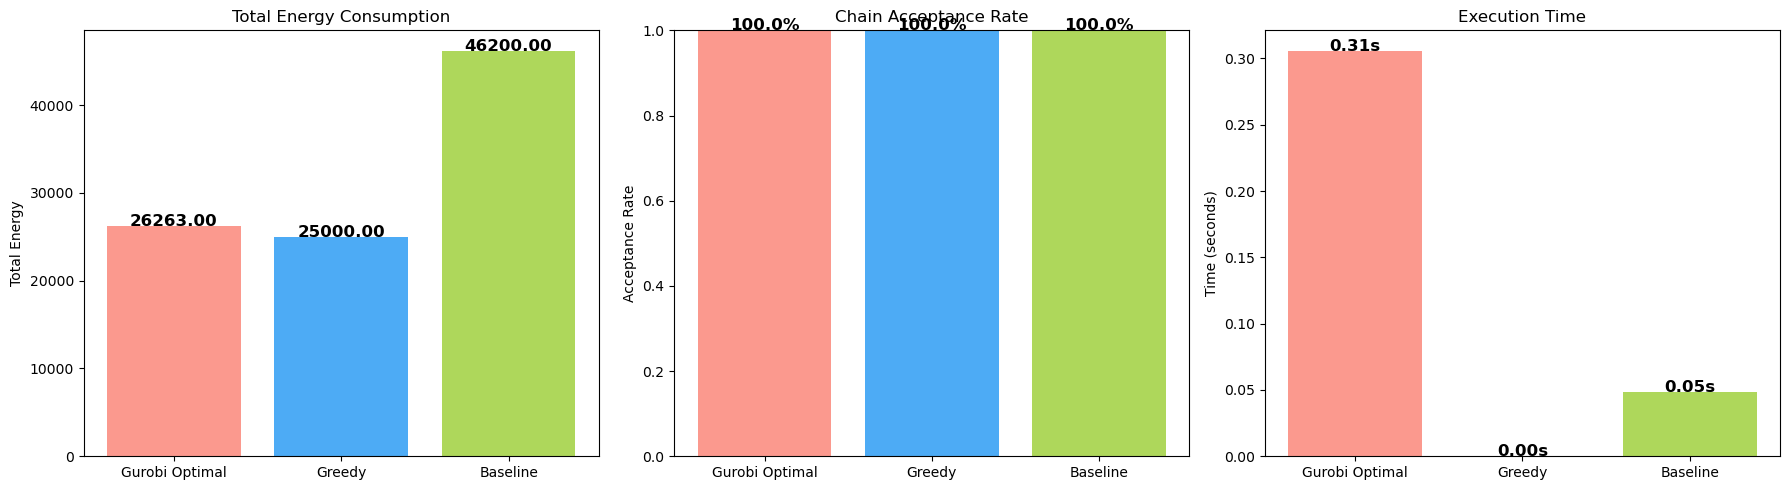

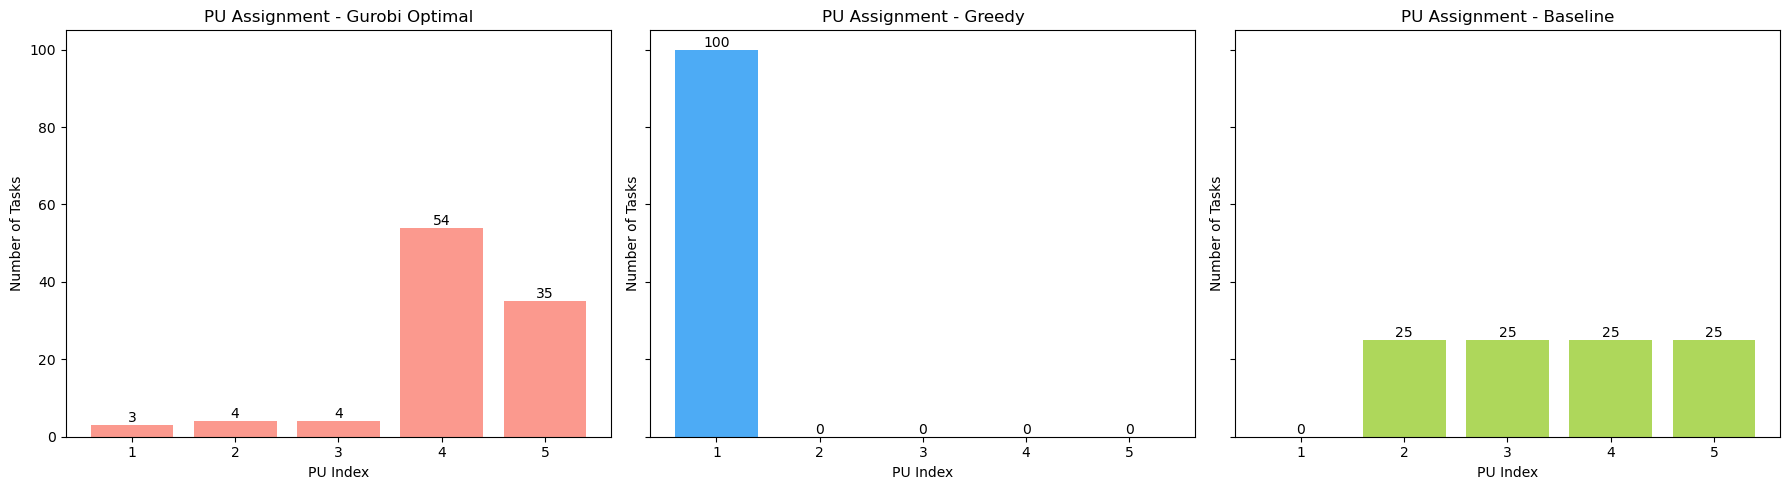

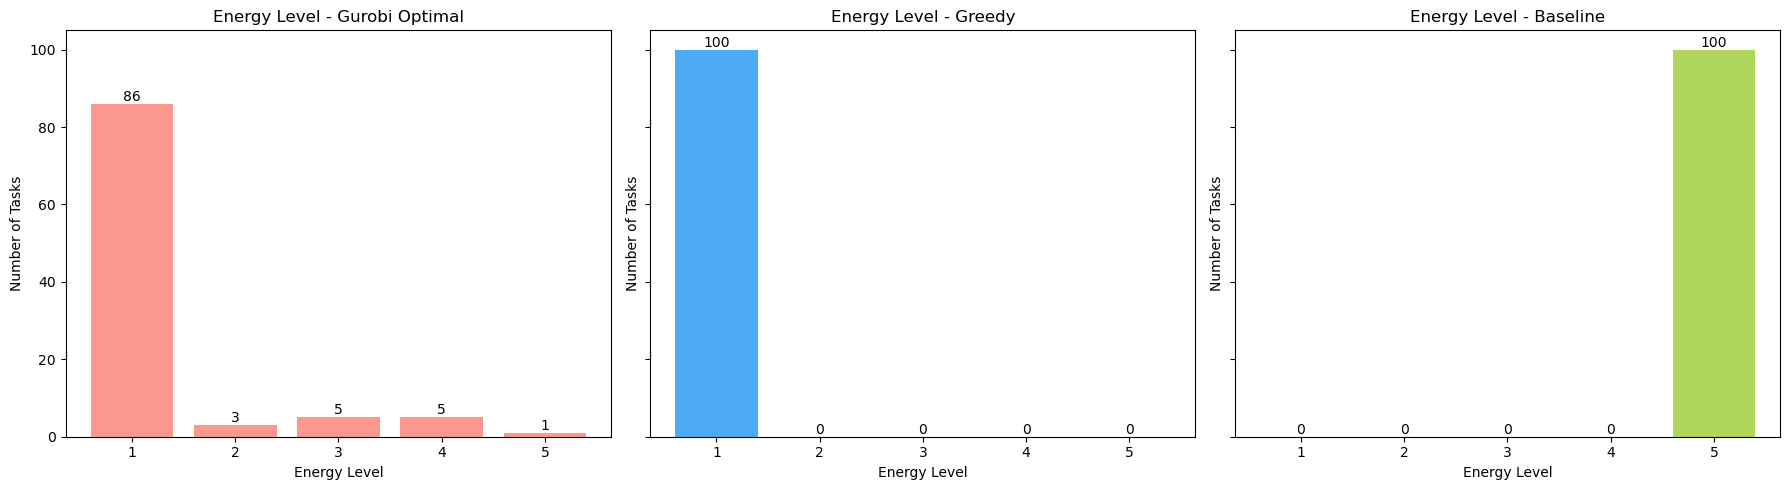

In [12]:
# 颜色设置
colors = ['#FA8072', '#2196F3', '#9ACD32']
labels = ['Gurobi Optimal', 'Greedy', 'Baseline']

# === 综合对比图 ===
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 总能耗
axes[0].bar(labels, [optimal_total_energy, greedy_total_energy, baseline_total_energy], color=colors, alpha=0.8)
axes[0].set_title('Total Energy Consumption')
axes[0].set_ylabel('Total Energy')
for i, v in enumerate([optimal_total_energy, greedy_total_energy, baseline_total_energy]):
    axes[0].text(i, v, f'{v:.2f}', ha='center', fontsize=12, fontweight='bold')

# 接受链比例
axes[1].bar(labels, [optimal_acceptance_rate, greedy_acceptance_rate, baseline_acceptance_rate], color=colors, alpha=0.8)
axes[1].set_title('Chain Acceptance Rate')
axes[1].set_ylabel('Acceptance Rate')
axes[1].set_ylim(0, 1)
for i, v in enumerate([optimal_acceptance_rate, greedy_acceptance_rate, baseline_acceptance_rate]):
    axes[1].text(i, v, f'{v:.1%}', ha='center', fontsize=12, fontweight='bold')

# 执行时间
axes[2].bar(labels, [optimal_time, greedy_time, baseline_time], color=colors, alpha=0.8)
axes[2].set_title('Execution Time')
axes[2].set_ylabel('Time (seconds)')
for i, v in enumerate([optimal_time, greedy_time, baseline_time]):
    axes[2].text(i, v, f'{v:.2f}s', ha='center', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# === PU Assignment对比 ===
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
methods_assignments = [optimal_pu_assignments, greedy_pu_assignments, baseline_pu_assignments]
for idx, ax in enumerate(axes):
    counts, bins, bars = ax.hist(methods_assignments[idx], bins=np.arange(1, m + 2) - 0.5, color=colors[idx], alpha=0.8, rwidth=0.8)
    ax.set_title(f'PU Assignment - {labels[idx]}')
    ax.set_xlabel('PU Index')
    ax.set_ylabel('Number of Tasks')
    ax.set_xticks(range(1, m + 1))
    for bar, count in zip(bars, counts):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height, int(count), ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.show()

# === Energy Level对比 ===
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
methods_energy_levels = [optimal_energy_levels, greedy_energy_levels, baseline_energy_levels]
for idx, ax in enumerate(axes):
    counts, bins, bars = ax.hist(methods_energy_levels[idx], bins=np.arange(1, K + 2) - 0.5, color=colors[idx], alpha=0.8, rwidth=0.8)
    ax.set_title(f'Energy Level - {labels[idx]}')
    ax.set_xlabel('Energy Level')
    ax.set_ylabel('Number of Tasks')
    ax.set_xticks(range(1, K + 1))
    for bar, count in zip(bars, counts):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height, int(count), ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.show()
